# Hysteresis Processing

The Jackson and Solheid, 2010 paper is a seminal manuscript on forward progress of quantitative hysteresis processing that provides ways for data quality assessment and parameter uncertainty estimates. 

## Workflow for hysteresis processing

1) grid the original data by averaging field step size, and interpolate both the upper and lower branches of the hysteresis loop to the same field steps.
2) perform a linear fit on the original loop data for the high field slope (typically > 80% max field values and < 97% max field value) and subtract the linear fit from all the gridded data points. 
 perform paramagnetic/diamagnetic slope correction on the gridded data
 here we use both the upper and lower branches of the hysteresis loops and invert data points in the third quadrant to the first quadrant for line fitting (ordinary least squares) to estimate the paramagnetic/diamagnetic slope.
 
3) perform linearity test on the girdded original data (high field slope correction not applied)

4) at the same time, centering the high-field slope corrected data, and estiamte the optimal values for field and moment offsets.
 Note that when iterating through different H_offset values on the inverted lower branch, the upper and lower branches will have a H field range mismatch. To account for this, in this code we just use the overlapping region for interpolation and ANOVA statistic.

 Testing with synthetic data shows that the exact offset results from this code is slightly different from that of the IRM database. But the results from this function `hyst_loop_centering` are self-consistent (add synthetic offset + or - results in the same corrected R^2 while the IRM function does not). Given that both functions finds the correct offset values, I use the new function

5) calcualte the Q value to represent the signal/noise ratio (data quality) of the whole loop (ferromagnetic component + paramagnetic (also + diamagnetic component)) after centering. 
6) re-grid the original data with applying the estimated optimal values for field and moment offsets.
7) calcualte H and M errors for each data point.
8) calculate mrh, E_hys, Brh, Bih
9) use the sum of M errors to estimate signal drift correction
10) test saturation of the loop by calculating the FN60, 70, 80 statistics and determine where the loop start to saturate.
11) re-apply high field slope correction to the drift-corrected data
12) calculate the Qf value using the drift-corrected, high-field slope corrected data for the ferromagnetic component quanlity estiamtion.
13) calculate Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc



## Questions
question: 

difference between loop_errcor and loop_errcor2?

does offset estimate only offset H not M, or does it do both? The paper only talks about offsetting H?

why do we use the same high field slope for correction after centering? Shouldn't we re-fit for the high-field slope afterwards?



## Install and import packages

In [3]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
from scipy.optimize import minimize, brent
from numpy.linalg import svd, lstsq
pd.set_option('display.max_columns', 500)
import ipywidgets as widgets

import matplotlib.pyplot as plt
import math

from IPython.display import display, HTML, clear_output, Javascript 

from loop_grid import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
ipmag.igrf([2024, 0, 44.975236, -93.233911])

array([2.495534809776402e-01, 7.127596437974265e+01,
       5.492295468757294e+04])

## Import data

To pull data from MagIC, you need to define 3 parameters below:
 - `magic_id`
 - `share_key`
 - `dir_path`
 
### If you are pulling data off of an existing, published dataset on MagIC:
 - look for the MagIC contribution link associated with the dataset
 <img src="example_data/hyst/Images/public_cb_example.png" alt="public_cb_example" width="800" />

 - leave the share key blank `share_key = ''`
 - set the dir_path to where you want the data to be stored
 
### If you are pulling date off of a private MagIC contribution:
 - find the contribution in your private workspace and click on share
  <img src="example_data/hyst/Images/private_cb_example.png" alt="private_cb_example" width="800" />

- set the dir_path to where you want the data to be stored

## Remote Data
You can directly pull data from MagIC by providing the magic_id and share_key. If you do not have a share_key (i.e. a published dataset), leave it as an empty string.


In [5]:
# define these three parameters to match your data
magic_id = '19216'
share_key = ''
dir_path = 'example_data/hyst'

result, magic_file = ipmag.download_magic_from_id(magic_id, directory=dir_path, share_key=share_key)
ipmag.unpack_magic(magic_file, dir_path)
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

Download successful. File saved to: example_data/hyst/magic_contribution_19216.txt
working on:  'contribution'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/contribution.txt
contribution  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/contribution.txt
working on:  'locations'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/locations.txt
working on:  'sites'
18  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/sites.txt
working on:  'samples'
92  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/samples.txt
samples  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/samples

,citations,description,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_x,magn_y,magn_z,meas_field_dc,meas_freq,measurement,method_codes,quality,sequence,specimen,standard,susc_chi_mass,timestamp,treat_ac_field,treat_dc_field,treat_dc_field_phi,treat_dc_field_theta,treat_step_num,treat_temp
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,
CNF1-1b_hysteresis_1,This study,Mf_BKcor_name=0.138109131594802,NaN,NaN,CNF1-1b_hysteresis,None,1.099976e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_1,LP-HYS,g,1,CNF1-1b,u,NaN,2018,NaN,0.975792,NaN,NaN,1,300.0
CNF1-1b_hysteresis_2,This study,Mf_BKcor_name=0.138394698338928,NaN,NaN,CNF1-1b_hysteresis,None,1.103909e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_2,LP-HYS,g,2,CNF1-1b,u,NaN,2018,NaN,0.970800,NaN,NaN,2,300.0
CNF1-1b_hysteresis_3,This study,Mf_BKcor_name=0.138277046217403,NaN,NaN,CNF1-1b_hysteresis,None,1.104140e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_3,LP-HYS,g,3,CNF1-1b,u,NaN,2018,NaN,0.965802,NaN,NaN,3,300.0
CNF1-1b_hysteresis_4,This study,Mf_BKcor_name=0.138210302091402,NaN,NaN,CNF1-1b_hysteresis,None,1.104880e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_4,LP-HYS,g,4,CNF1-1b,u,NaN,2018,NaN,0.960821,NaN,NaN,4,300.0
CNF1-1b_hysteresis_5,This study,Mf_BKcor_name=0.138028487821671,NaN,NaN,CNF1-1b_hysteresis,None,1.104465e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_5,LP-HYS,g,5,CNF1-1b,u,NaN,2018,NaN,0.955830,NaN,NaN,5,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CNFP6-9d_remanence_7,This study,Description=,204.618,60.8925,CNFP6-9d_remanence,None,6.960000e-07,1.870000e-09,-8.260000e-10,-3.780000e-10,1.630000e-09,NaN,NaN,CNFP6-9d_remanence_7,LP-ARM-AFD,g,45415,CNFP6-9d,u,NaN,2018,0.07,NaN,NaN,NaN,7,NaN
CNFP6-9d_remanence_8,This study,Description=,220.792,34.7740,CNFP6-9d_remanence,None,3.770000e-07,1.010000e-09,-6.290000e-10,-5.430000e-10,5.770000e-10,NaN,NaN,CNFP6-9d_remanence_8,LP-ARM-AFD,g,45416,CNFP6-9d,u,NaN,2018,0.10,NaN,NaN,NaN,8,NaN
CNFP6-9d_remanence_9,This study,Description=,209.009,1.8460,CNFP6-9d_remanence,None,3.550000e-07,9.540000e-10,-8.340000e-10,-4.620000e-10,3.070000e-11,NaN,NaN,CNFP6-9d_remanence_9,LP-ARM-AFD,g,45417,CNFP6-9d,u,NaN,2018,0.12,NaN,NaN,NaN,9,NaN


## Local Data
If the magic file is already saved on your computer, use this instead. Set the file location under dir_path.

In [6]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/hyst/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('ECMB.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

working on:  'specimens'
26  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/specimens.txt
specimens  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/specimens.txt
working on:  'samples'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/samples.txt
samples  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/samples.txt
working on:  'sites'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/sites.txt
working on:  'locations'
16  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/locations.txt
working on:  'measurements'
8392  records written 

## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

In [7]:
# plot the hysteresis loop (only looking for 'LP-HYS')
specimen = rmag.make_hyst_plots2(measurements)

Dropdown(description='Method Code:', options=('LP-HYS',), value='LP-HYS')

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED23-8c', 'NED34-6c', 'NED36-8c…

Dropdown(description='Experiment:', options=('IRM-VSM3-LP-HYS-218845', 'IRM-VSM3-LP-BCR-BF-218846'), value='IR…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

Output()

In [68]:
# extract the specimen specific data
hyst_data, data_type = rmag.extract_hysteresis_data(measurements, specimen.value)

Data Extracted!


## Plot the raw hysterisis data

In [69]:
example_fields = hyst_data['meas_field_dc']
example_magnetizations = hyst_data['magn_mass']

In [70]:
def plot_hysteresis_loop(ax, field, magnetization, **kwargs):
    '''
    function to plot a hysteresis loop

    Parameters
    ----------
    ax : matplotlib axis object
        axis object to plot the data
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values
    **kwargs : keyword arguments
        additional keyword arguments to pass to the plot function

    Returns
    -------
    ax : matplotlib axis object
        axis object with the hysteresis loop plotted
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    ax.plot(field, magnetization, '-', **kwargs)
    ax.set_xlabel('Field (T)', fontsize=12)
    ax.set_ylabel('Magnetization (Am$^2$/kg)', fontsize=12)
    ax.set_title('Hysteresis Loop', fontsize=12)
    ax.grid(True)
    return ax

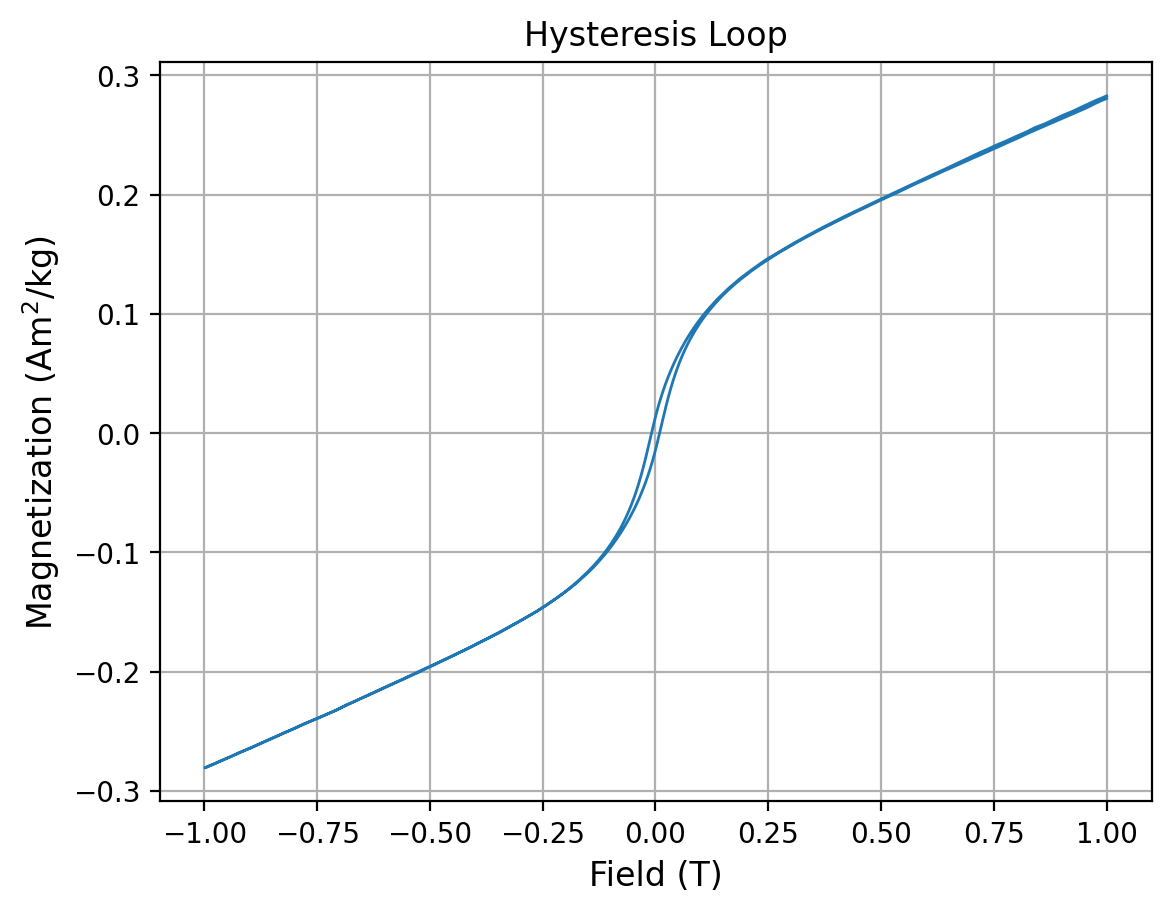

In [71]:
fig, ax = plt.subplots()
ax = plot_hysteresis_loop(ax, example_fields, example_magnetizations, linewidth=1)
plt.show()

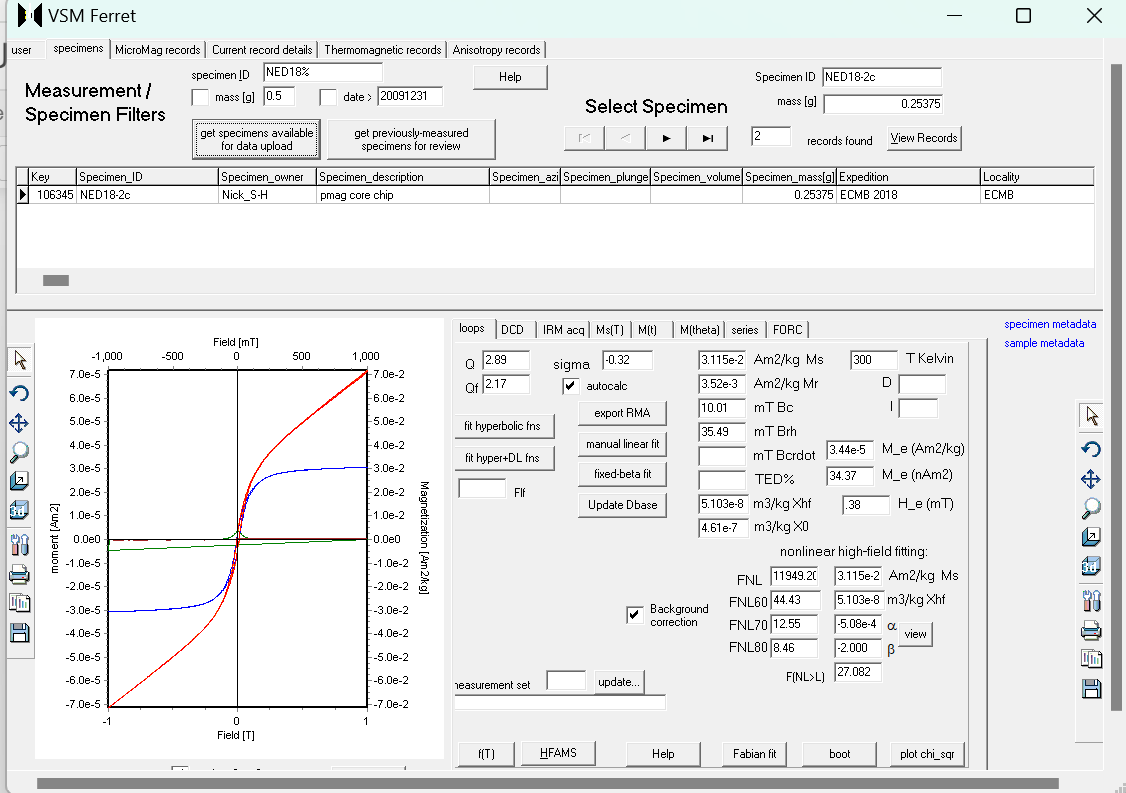

# Loop processing

follow the workflow presented in Paterson et al., 2018

<img src="example_data/hyst/Images/hyst_loo_processing_workflow.png" alt="workflow" width="400" />



## Gridding the raw data

- An ideal hysteresis loop should have perfect symmetry. But in practice the upper branch and lower branch never have the exact same field steps. To make the data comparable, we need to grid the data to the same field steps.
- Hystlab takes the approach of inverting the lower branch and interpolate it through the field steps of the upper branch.
- The IRM software takes the approach of gridding both branches to a common array of field steps.
- In this package, we will use the IRM approach through the `grid_hysteresis_loop` function. The field step interval is calculated by averaging the step intervals throughout the raw data. 

In [72]:
def split_hysteresis_loop(field, magnetization):
    '''
    function to split a hysteresis loop into upper and lower branches
        by the change of sign in the applied field gradient

    Parameters
    ----------
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values

    Returns
    -------
    upper_branch : tuple
        tuple of field and magnetization values for the upper branch
    lower_branch : tuple
        tuple of field and magnetization values for the lower branch
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    # identify loop turning point by change in sign of the field difference
    # split the data into upper and lower branches
    field_gradient = np.gradient(field)
    # There should just be one turning point in the field gradient
    turning_points = np.where(np.diff(np.sign(field_gradient)))[0]
    if len(turning_points) > 1:
        raise ValueError('More than one turning point found in the gradient of the applied field')
    turning_point = turning_points[0]
    upper_branch = [field[:turning_point+1], magnetization[:turning_point+1]]
    # sort the upper branch in reverse order
    upper_branch = [field[:turning_point+1][::-1], magnetization[:turning_point+1][::-1]]
    lower_branch = [field[turning_point+1:], magnetization[turning_point+1:]]
    
    return upper_branch, lower_branch

def grid_hysteresis_loop(field, magnetization):
    '''
    function to grid a hysteresis loop into a regular grid
        with grid intervals equal to the average field step size calculated from the data

    Parameters
    ----------
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values

    Returns
    -------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    # calculate the average field step size
    field_step = np.mean(np.abs(np.diff(field)))

    # grid the hysteresis loop
    upper_field = np.arange(np.max(field), np.min(field), -field_step)
    lower_field = upper_field[::-1]
    grid_field = np.concatenate([upper_field, lower_field])
    upper_branch, lower_branch = split_hysteresis_loop(field, magnetization)
    upper_branch_itp = np.interp(upper_field, upper_branch[0], upper_branch[1])
    lower_branch_itp = np.interp(lower_field, lower_branch[0], lower_branch[1])
    grid_magnetization = np.concatenate([upper_branch_itp, lower_branch_itp])

    return grid_field, grid_magnetization

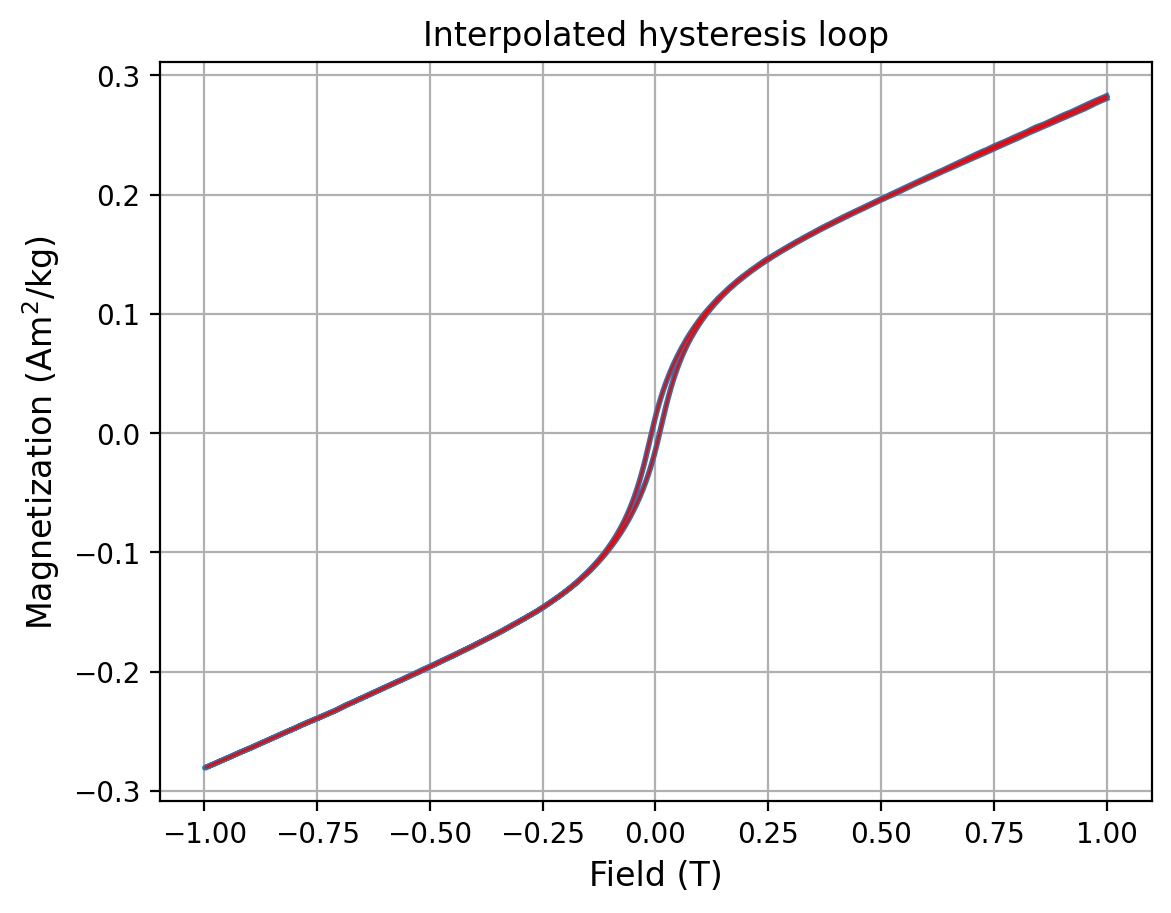

In [73]:
grid_example_fields, grid_example_magnetizations = grid_hysteresis_loop(example_fields, example_magnetizations)

fig, ax = plt.subplots()
ax = plot_hysteresis_loop(ax, example_fields, example_magnetizations, color='C0', linewidth=2)
ax = plot_hysteresis_loop(ax, grid_example_fields, grid_example_magnetizations, color='r', linewidth=0.8)
ax.set_title('Interpolated hysteresis loop', fontsize=12)
plt.show()

## Hysteresis loop linearity test
- perform linearity test on the raw data
- if it passes linearity test, this means there is minimal ferromagnetic contribution in the data, end loop processing here
- if it fails linearity test, continue with loop processing
- following the IRM convention, we will use the gridded loop for this test
- the FNL value coming out of the ANOVA statistcs is the basis for the linearity test. 
- If FNL exceeds a value of 1.25, linearity can be rejected with 95% confidence, and we should move on to the next step of loop processing.
- If FNL is less than 1.25, the loop is considered linear, and we should calculate the y intercept of the best fit line through the loop and correct for the M offset on the raw data points. After this step, the data is good for archiing.

The FNL value is very sensitive to the way the data is gridded. With a good loop like the shown example data, the FNL value can change from ~ 2k - 10k. 
- However, it is the qualitative result assessment that the FNL value is > 1.25 which signals the loop is non-linear that actually matters!

In [74]:
def ANOVA(xs, ys):
    '''
    ANOVA statistics for linear regression
    
    Parameters
    ----------
    xs : numpy array
        x values
    ys : numpy array
        y values

    Returns
    -------
    results : dict
        dictionary of the results of the ANOVA calculation
        and intermediate statistics for the ANOVA calculation

    '''

    xs = np.array(xs)
    ys = np.array(ys)

    ys_mean = np.mean(ys)

    # fit the gridded data by a straight line
    slope, intercept = np.polyfit(xs, ys, 1)

    # AVOVA calculation
    # total sum of squares for the dependent variable (magnetization)
    SST = np.sum((ys - ys_mean) ** 2)

    # sum of squares due to regression
    SSR = np.sum((slope * xs + intercept - ys_mean) ** 2)
    
    # the remaining unexplained variation (noise and lack of fit)
    SSD = SST-SSR

    R_squared = SSR/SST

    results = {'slope':slope,
                'intercept':intercept,
                'SST':SST,
                'SSR':SSR,
                'SSD':SSD,
                'R_squared': R_squared}
    
    return results

def hyst_linearity_test(grid_field, grid_magnetization):
    '''
    function for testing the linearity of a hysteresis loop

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    results : dict
        dictionary of the results of the linearity test
        and intermediate statistics for the ANOVA calculation

    '''

    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)

    anova_results = ANOVA(grid_field, grid_magnetization)

    # fit the gridded data by a straight line
    slope, intercept = anova_results['slope'], anova_results['intercept']

    # AVOVA calculation
    # total sum of squares for the dependent variable (magnetization)
    SST = anova_results['SST']

    # sum of squares due to regression
    SSR = anova_results['SSR']
    
    # the remaining unexplained variation (noise and lack of fit)
    SSD = anova_results['SSD']

    R_squared = anova_results['R_squared']

    # invert the lower branch to match the upper branch
    # and calculate the differences between the upper and the inverted lower branch
    # for any loop shifts and drift that are due to noise alone
    SSPE = np.sum((upper_branch[1] - (-lower_branch[1][::-1])) ** 2)  / 2

    # calculate the lack of fit statistic
    SSLF = SSD - SSPE

    # mean square pure error
    MSPE = 2 * SSPE / len(grid_field)

    # mean square error due to lack of fit
    MSLF = SSLF / (len(grid_field)/2 - 2)

    # mean squares due to regression
    MSR = SSR / (len(grid_field) - 2)

    # mean squares due to noise
    MSD = SSD / (len(grid_field) - 2)

    # square mean pure error
    MSPE = SSPE / (len(grid_field) / 2)

    # square mean lack of fit
    MSLF = SSLF / (len(grid_field) / 2 - 2)

    # F-ratio for the linear component
    FL = MSR / MSD

    # F-ratio for the non-linear component
    FNL = MSLF / MSPE

    results = {'SST':SST, 
            'SSR':SSR,
            'SSD':SSD,
            'R_squared': R_squared, 
            'SSPE':SSPE,
            'SSLF':SSLF, 
            'MSPE':MSPE,
            'MSLF':MSLF,
            'MSR':MSR, 
            'MSD':MSD, 
            'MSPE':MSPE, 
            'MSLF':MSLF, 
            'FL':FL, 'FNL':FNL, 
            'slope':slope, 'intercept':intercept, 
            'loop is linear':FNL < 1.25,}

    return results


In [75]:
linearity_test_results = hyst_linearity_test(grid_example_fields, grid_example_magnetizations)
print(linearity_test_results['FNL'])
print(linearity_test_results['loop is linear'])

3168.8299770331296
False


## Centering the loop

- centering the loop involves inverting the gridded lower branch and interpolating it according to the upper branch, and calculating M(H) vs M_inv(-H, H_offset) to find the optimal values for field and moment offsets.
- the optimal values for the offset field and the offset moment are also very sensitive to the way the raw loop is gridded.
- the best way to deal with this is to propagate uncertaintis associated with all the estimated parameters through the loop processing workflow, which is not implemented anywhere. 
- here we implement a brent algorithm to find the optimal value for the field offsets that results in the best linear fit between M(H) vs M_inv(-H, H_offset). 
- the associated moment offset is the 1/2 of the y intercept of the best fit line with the optimized field offset.
- Note that centering the loop will change the inversion symmetry of the loop, which can be visualized by plotting the centered loop as is and its inversion through origin.

In [76]:
def hyst_loop_centering(grid_field, grid_magnetization):
    '''
    function for finding the optimum applied field offset value for the lower branch of a hysteresis loop
        that results in the best linear fit between the upper branch and the inverted and offsetted lower branch

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    opt_H_offset : float
        optimized applied field offset value for the loop
    opt_M_offset : float
        calculated magnetization offset value for the loop based on the optimized applied field offset
        (intercept of the fitted line using the upper branch and the inverted and optimally offsetted lower branch)
    R_squared : float
        R-squared value of the linear fit between the upper branch and the inverted and offsetted lower branch

    '''
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    lower_branch_inverted = [-lower_branch[0][::-1], -lower_branch[1][::-1]]
    global opt_M_offset
    # find the optimized H_offset that minimizes the correlation between M(H) and -M_inv (-H, H_offset)
    def calc_H_offset(H_offset):
        global opt_M_offset
        # shift the lower branch by the H_offset
        lower_branch_inverted_shifted = [lower_branch_inverted[0] + H_offset, lower_branch_inverted[1]]

        # find the max of the min of the two branches and the min of the max of the two branches
        # to find the overlapping region
        upper_bound = np.min([np.max(upper_branch[0]), np.max(lower_branch_inverted_shifted[0])])
        lower_bound = np.max([np.min(upper_branch[0]), np.min(lower_branch_inverted_shifted[0])])

        # find the overlapping region
        upper_overlapping_idx = np.where((upper_branch[0] >= lower_bound) & (upper_branch[0] <= upper_bound))
        upper_branch_overlapping = [upper_branch[0][upper_overlapping_idx], upper_branch[1][upper_overlapping_idx]]
        lower_overlapping_idx = np.where((lower_branch_inverted_shifted[0] >= lower_bound) & (lower_branch_inverted_shifted[0] <= upper_bound))
        lower_branch_overlapping = [lower_branch_inverted_shifted[0][lower_overlapping_idx], lower_branch_inverted_shifted[1][lower_overlapping_idx]]

        
        H_offset_anova = ANOVA(upper_branch_overlapping[1], lower_branch_overlapping[1])
        opt_M_offset = H_offset_anova['intercept']/2
        # correlation_coefficient = np.corrcoef(upper_branch[1], lower_branch_itp)
        # R_squared = correlation_coefficient[0,1] ** 2
        return 1-H_offset_anova['R_squared']

    opt_H_offset, inv_R_squared, _, _ = brent(calc_H_offset, brack=(-np.max(grid_field)/2, 0, np.max(grid_field)/2), tol=1e-6, full_output=True)
    R_squared = 1-inv_R_squared
    # signal to noise ratio
    M_sn = 1/(np.sqrt(1-R_squared))
    Q = np.log10(M_sn)
    results = {'opt_H_offset':opt_H_offset/2, 'opt_M_offset':opt_M_offset, 'R_squared':R_squared, 'M_sn':M_sn, 'Q':Q}
    return results

In [77]:
example_data_cetnering_results = hyst_loop_centering(grid_example_fields, grid_example_magnetizations)
example_data_cetnering_results

{'opt_H_offset': 8.176539019456157e-12,
 'opt_M_offset': 0.00016703289661448614,
 'R_squared': 0.9999904458005032,
 'M_sn': 323.5212763829933,
 'Q': 2.5099028473289255}

##  Apply the H and M offsets 

In [78]:
grid_example_fields_centered = grid_example_fields + example_data_cetnering_results['opt_H_offset']
grid_example_magnetizations_centered = grid_example_magnetizations - example_data_cetnering_results['opt_M_offset']

## Apply the high field slope correction

In [79]:

def linear_HF_fit(field, magnetization, HF_cutoff=0.8):
    '''
    function to fit a linear function to the high field portion of a hysteresis loop

    Parameters
    ----------
    field : numpy array or list
        raw hysteresis loop field values
    magnetization : numpy array or list
        raw hysteresis loop magnetization values

    Returns
    -------
    slope : float
        slope of the linear fit
        can be interpreted to be the paramagnetic/diamagnetic susceptibility
    intercept : float
        y-intercept of the linear fit
        can be interpreted to be the saturation magnetization of the ferromagnetic component
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'
    assert HF_cutoff > 0 and HF_cutoff < 1, 'Portion must be between 0 and 1'

    # adopting IRM's max field cutoff at 97% of the max field
    max_field_cutoff = 0.97
    
    field = np.array(field)
    magnetization = np.array(magnetization)

    # filter for the high field portion of each branch

    high_field_index = np.where((np.abs(field) >= HF_cutoff*np.max(np.abs(field))) & (np.abs(field) <= max_field_cutoff*np.max(np.abs(field))))[0]

    # invert points in the third quadrant to the first
    high_field = np.abs(field[high_field_index])
    high_field_magnetization = np.abs(magnetization[high_field_index])

    # the slope would be the paramagnetic/diamagnetic susceptibility
    # the y-intercept would be the Ms value (saturation magnetization of the ferromagnetic component)
    slope, intercept = np.polyfit(high_field, high_field_magnetization, 1)
    
    return slope, intercept

def hyst_slope_correction(grid_field, grid_magnetization, slope):
    '''
    function for subtracting the paramagnetic/diamagnetic slope from a hysteresis loop
         the input should be gridded field and magnetization values

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values
    slope : float
        slope of the linear fit

    Returns
    -------
    grid_magnetization_ferro: numpy array
        corrected ferromagnetic component of the magnetization
    '''
    assert len(grid_field) == len(grid_magnetization), 'Field and magnetization arrays must be the same length'
    
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    grid_magnetization_ferro = grid_magnetization - slope*grid_field

    return grid_magnetization_ferro

In [80]:
HF_slope, HF_intercept = linear_HF_fit(grid_example_fields_centered, grid_example_magnetizations_centered, HF_cutoff=0.8)
grid_example_magnetizations_centered_HF_corr = hyst_slope_correction(grid_example_fields_centered, grid_example_magnetizations_centered, HF_slope)
HF_slope, HF_intercept

(0.16735208707754556, 0.11380817955127158)

## Decompose the corrected loop into the induced and remanent components

In [81]:
def calc_Mrh_Mih(grid_field, grid_magnetization):
    '''
    function to calculate the Mrh and Mih values from a hysteresis loop

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    H : numpy array
        field values of the upper branch (the two branches should have the same field values)
    Mrh : float
        remanent magnetization value
    Mih : float
        induced magnetization value
    Me : numpy array
        error on M(H), calculated as the subtraction of the inverted lower branch from the upper branch

    '''
    # calculate Mrh bu subtracting the upper and lower branches of a hysterisis loop
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    grid_field = grid_field
    grid_magnetization = grid_magnetization

    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    # make sure the x values for the branches are exactly the same
    assert np.all(upper_branch[0] == lower_branch[0]), 'Field values for the upper and lower branches are not the same'

    Mrh = (upper_branch[1] - lower_branch[1])/2
    Mih = (upper_branch[1] + lower_branch[1])/2
    Me = upper_branch[1] + lower_branch[1][::-1]

    H = upper_branch[0]
    return H, Mrh, Mih, Me

In [82]:
example_H, example_Mrh, example_Mih, example_Me = calc_Mrh_Mih(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr)

## Test loop saturation
- check if the loop is saturated beyond 60%, 70%, or 80% of the max field value by calculating the FN60, FN70, FN80 statistics
- if none of the FN values is < 2.5, the loop is considered to be not saturated at high fields, and that a non-linear fit correction is recommended

In [85]:
def loop_saturation_stats(field, magnetization, HF_cutoff=0.8, max_field_cutoff=0.97):
    '''
    ANOVA statistics for the high field portion of a hysteresis loop
    
    Parameters
    ----------
    field : numpy array
        field values
    magnetization : numpy array
        magnetization values
    HF_cutoff : float
        high field cutoff value
        default is 0.8

    Returns
    -------
    results : dict
        dictionary of the results of the ANOVA calculation
        and intermediate statistics for the ANOVA calculation

    '''
    field = np.array(field)
    magnetization = np.array(magnetization)

    # filter for the high field portion of each branch
    pos_high_field_index = np.where((field >= HF_cutoff*np.max(np.abs(field))) & (field <= max_field_cutoff*np.max(np.abs(field))))[0]
    neg_high_field_index = np.where((field <= -HF_cutoff*np.max(np.abs(field))) & (field >= -max_field_cutoff*np.max(np.abs(field))))[0]
    # invert points in the third quadrant to the first
    pos_high_field = np.abs(field[pos_high_field_index])
    pos_high_field_magnetization = np.abs(magnetization[pos_high_field_index])
    neg_high_field = np.abs(field[neg_high_field_index])
    neg_high_field_magnetization = np.abs(magnetization[neg_high_field_index])

    high_field = np.concatenate([pos_high_field, neg_high_field])
    high_field_magnetization = np.concatenate([pos_high_field_magnetization, neg_high_field_magnetization])

    anova_results = ANOVA(high_field, high_field_magnetization)
    SST = anova_results['SST']
    SSR = anova_results['SSR']
    SSD = anova_results['SSD']
    R_squared = anova_results['R_squared']

    SSPE = np.sum((pos_high_field_magnetization - neg_high_field_magnetization[::-1])**2 / 2)
    SSLF = SSD - SSPE
    MSR = SSR / (len(high_field) - 2)
    MSD = SSD / (len(high_field) - 2)
    MSPE = SSPE / (len(high_field) / 2)

    FL = MSR / MSD
    FNL = SSLF / MSPE

    results = {'SST':SST,
                'SSR':SSR,
                'SSD':SSD,
                'R_squared': R_squared,
                'SSPE':SSPE,
                'SSLF':SSLF,
                'MSPE':MSPE,
                'MSR':MSR,
                'MSD':MSD,
                'FL':FL,
                'FNL':FNL}
    return results
    

def hyst_loop_saturation_test(grid_field, grid_magnetization, max_field_cutoff=0.97):
    '''
    function for testing the saturation of a hysteresis loop
        which is based on the testing of linearity of the loop in field ranges of 60%, 70%, and 80% of the maximum field (<97%)
    '''
    
    FNL60 = loop_saturation_stats(grid_field, grid_magnetization, HF_cutoff=0.6, max_field_cutoff = max_field_cutoff)['FNL']
    FNL70 = loop_saturation_stats(grid_field, grid_magnetization, HF_cutoff=0.7, max_field_cutoff = max_field_cutoff)['FNL']
    FNL80 = loop_saturation_stats(grid_field, grid_magnetization, HF_cutoff=0.8, max_field_cutoff = max_field_cutoff)['FNL']

    saturation_cutoff = 0
    if (FNL80 > 2.5) & (FNL70 > 2.5) & (FNL60 > 2.5):
        saturation_cutoff = 0.92 # IRM default
    else:
        if FNL80 < 2.5:  #saturated at 80%
            saturation_cutoff = 0.8
        if FNL70 < 2.5:  #saturated at 70%
            saturation_cutoff = 0.7
        if FNL60 < 2.5:  #saturated at 60%
            saturation_cutoff = 0.6
    results = {'FNL60':FNL60, 'FNL70':FNL70, 'FNL80':FNL80, 'saturation_cutoff':saturation_cutoff}

    return results


In [86]:
hyst_loop_saturation_test(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr)

{'FNL60': 113.47936282385429,
 'FNL70': 113.7964698295381,
 'FNL80': 73.07243719913453,
 'saturation_cutoff': 0.92}

## inspect the data at this checkpoint

- for good normal hysteresis loops, this is a good point to check the data processing
- usually data processing can end here
- but if apparent loop drip is noticed, we will need to move on to correct for such drift
- if the data is overall too noise, one will need to smooth the data by fitting hyperbolic functions or hyperbolic + logistic curves to the data and reprocess the loop to obtain meaningful results. (Another suggestion if this is the case is that to stack loops or redo the measurements with longer averaging times)

- at this step, let's plot the centered data; high field slope corrected data, the Mrh and Mih

{'FNL60': 113.47936282385429, 'FNL70': 113.7964698295381, 'FNL80': 73.07243719913453, 'saturation_cutoff': 0.92}


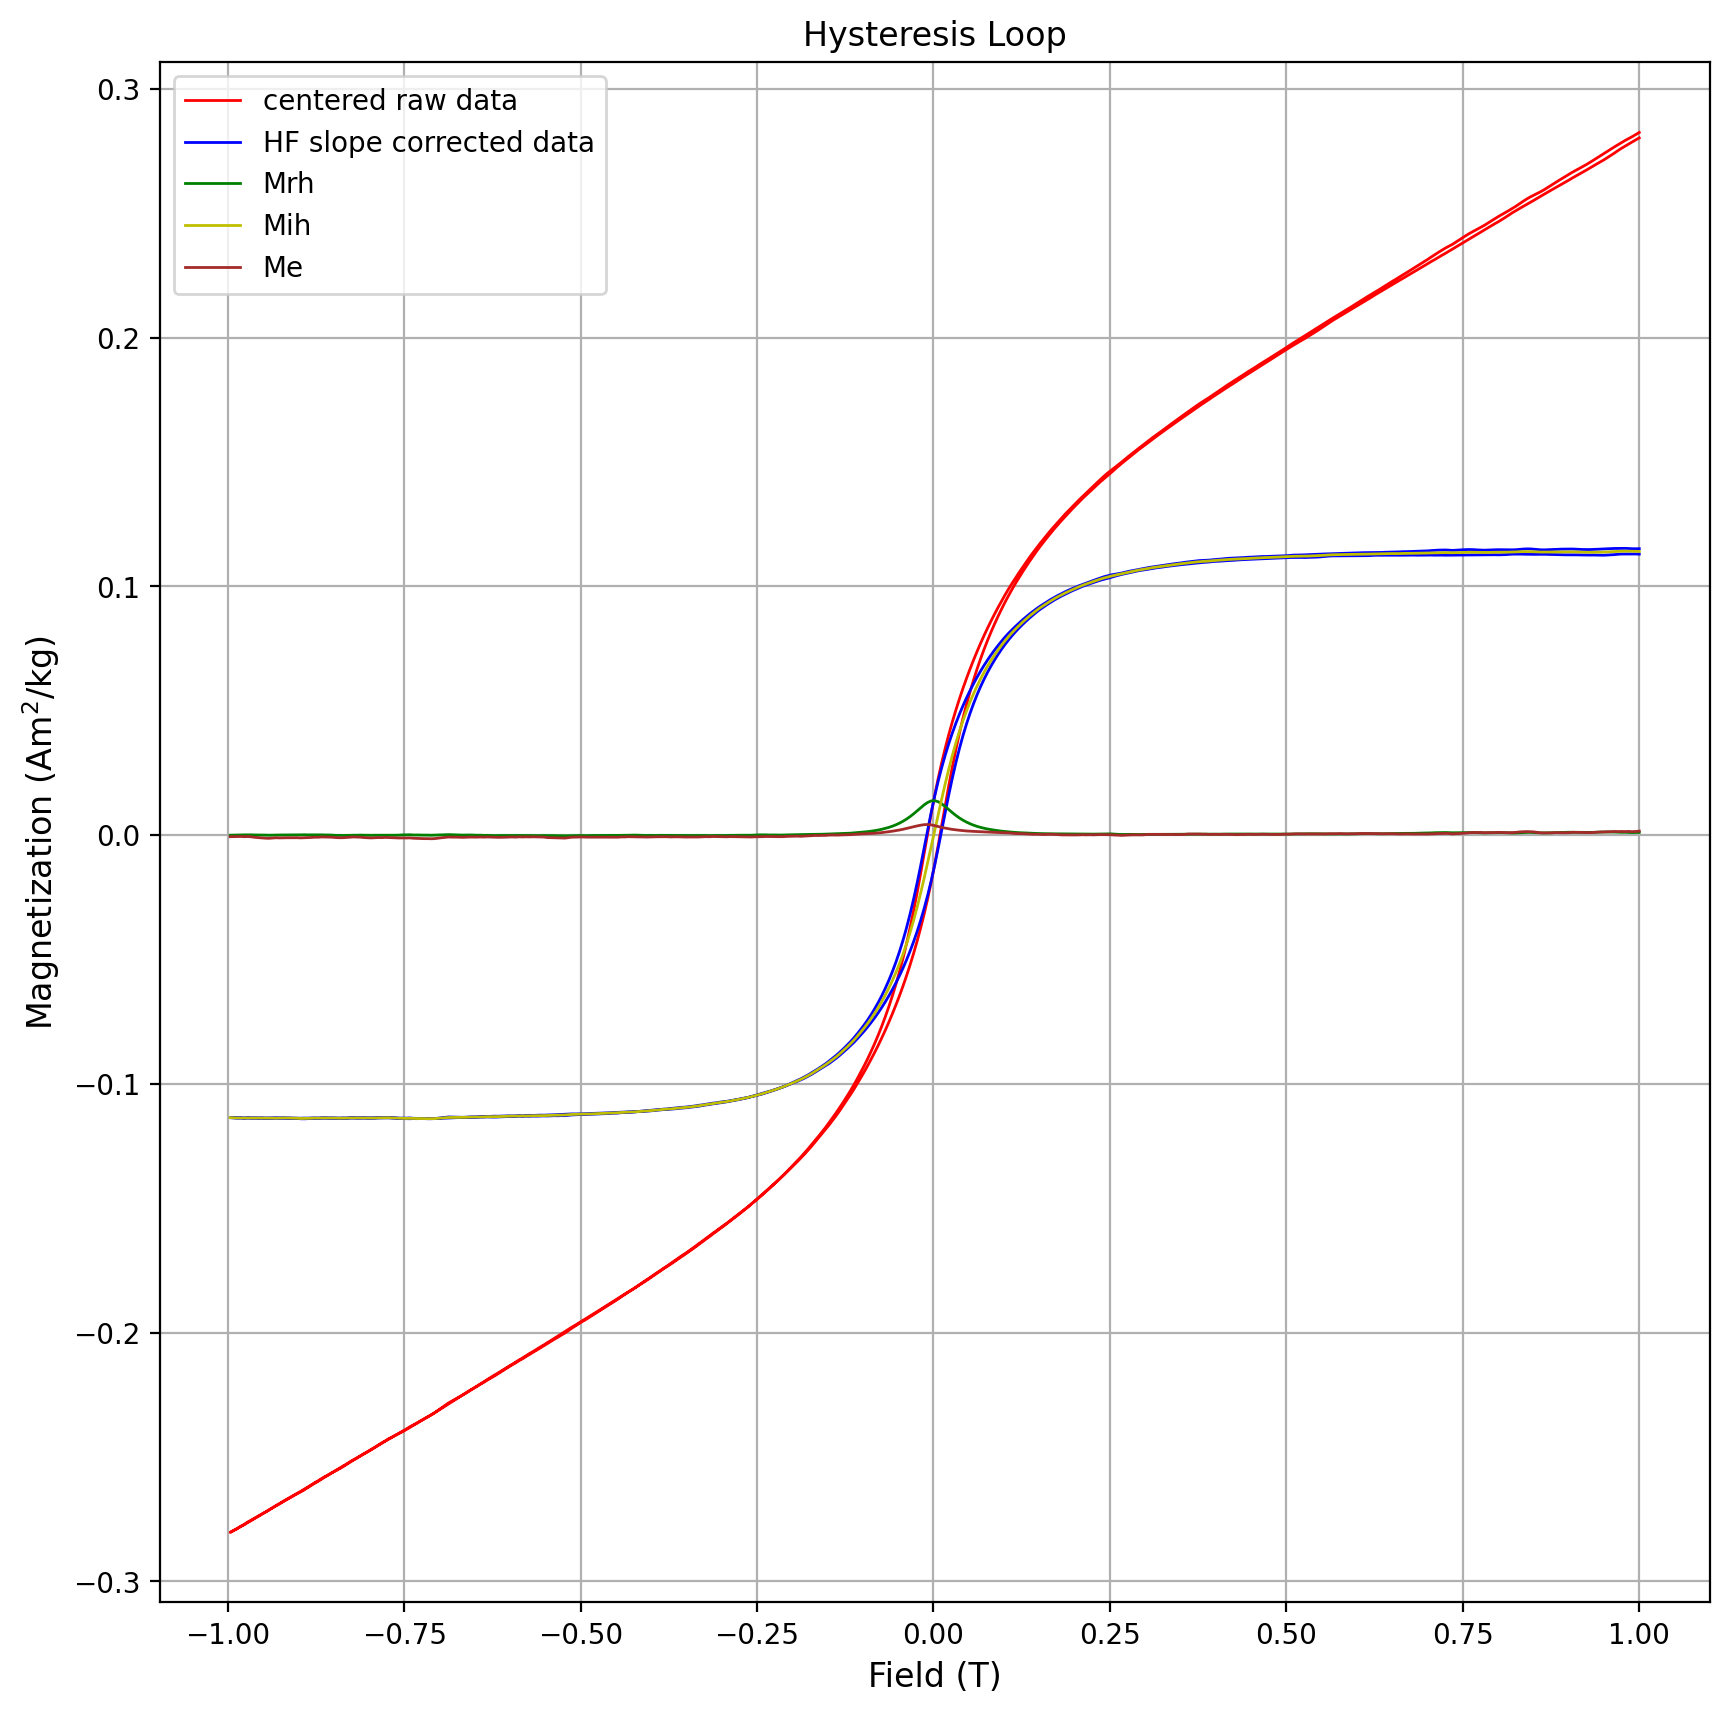

In [89]:
fig, ax =  plt.subplots(figsize=(10,10))
ax = plot_hysteresis_loop(ax, grid_example_fields_centered, grid_example_magnetizations_centered, color='r', linewidth=1, label='centered raw data')
ax.plot(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr, color='b', linewidth=1, label='HF slope corrected data')
ax.plot(example_H, example_Mrh, color='g', linewidth=1, label='Mrh')
ax.plot(example_H, example_Mih, color='y', linewidth=1, label='Mih')
ax.plot(example_H, example_Me, color='brown', linewidth=1, label='Me')

print(hyst_loop_saturation_test(grid_example_fields_centered, grid_example_magnetizations_centered_HF_corr))
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.01, 0.01)
plt.legend()
plt.show()

## Test loop drift

In [239]:











def hyst_loop_centering_plot(grid_field, grid_magnetization):
    '''
    function for finding the optimum applied field offset value for the lower branch of a hysteresis loop
        that results in the best linear fit between the upper branch and the inverted and offsetted lower branch

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    opt_H_offset : float
        optimized applied field offset value for the loop
    opt_M_offset : float
        calculated magnetization offset value for the loop based on the optimized applied field offset
        (intercept of the fitted line using the upper branch and the inverted and optimally offsetted lower branch)
    R_squared : float
        R-squared value of the linear fit between the upper branch and the inverted and offsetted lower branch

    '''
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    lower_branch_inverted = [-lower_branch[0][::-1], -lower_branch[1][::-1]]
    global opt_M_offset
    # find the optimized H_offset that minimizes the correlation between M(H) and -M_inv (-H, H_offset)
    def calc_H_offset(H_offset):
        global opt_M_offset
        # shift the lower branch by the H_offset
        lower_branch_inverted_shifted = [lower_branch_inverted[0] - 2*H_offset, lower_branch_inverted[1]]

        # find the max of the min of the two branches and the min of the max of the two branches
        # to find the overlapping region
        upper_bound = np.min([np.max(upper_branch[0]), np.max(lower_branch_inverted_shifted[0])])
        lower_bound = np.max([np.min(upper_branch[0]), np.min(lower_branch_inverted_shifted[0])])

        # find the overlapping region
        upper_overlapping_idx = np.where((upper_branch[0] >= lower_bound) & (upper_branch[0] <= upper_bound))
        upper_branch_overlapping = [upper_branch[0][upper_overlapping_idx], upper_branch[1][upper_overlapping_idx]]
        lower_overlapping_idx = np.where((lower_branch_inverted_shifted[0] >= lower_bound) & (lower_branch_inverted_shifted[0] <= upper_bound))
        lower_branch_overlapping = [lower_branch_inverted_shifted[0][lower_overlapping_idx], lower_branch_inverted_shifted[1][lower_overlapping_idx]]

        H_offset_anova = ANOVA(upper_branch_overlapping[1], lower_branch_overlapping[1])
        opt_M_offset = H_offset_anova['intercept']/2
        # correlation_coefficient = np.corrcoef(upper_branch[1], lower_branch_itp)
        # R_squared = correlation_coefficient[0,1] ** 2
        return 1-H_offset_anova['R_squared']

    fig, ax = plt.subplots(figsize=(8,6))
    inv_R_squared_list = []
    H_offset_list = np.linspace(-0.01, 0.01, 100)
    print(len(H_offset_list))
    for H_offset in H_offset_list:
        inv_R_squared_list.append(calc_H_offset(H_offset))
    ax.plot(H_offset_list, inv_R_squared_list)
    ax.set_xlabel('H_offset (T)', fontsize=12)
    ax.set_ylabel('1-R_squared', fontsize=12)
    ax.set_title('Optimization of H_offset', fontsize=12)
    print('Optimal H_offset:', H_offset_list[np.argmin(inv_R_squared_list)])
    return 






def hyst_loop_intercepts(field, magnetization):
    '''
    function for calculating axes intercepts of a given hysteresis loop
        input can be raw field and magnetization values or gridded ones
        calculations related to Hc are prone to failure in case of bad data quality (noisy data)

    Parameters
    ----------
    field : numpy array or list
        field values
    magnetization : numpy array or list
        magnetization values

    Returns
    -------
    results : dict
        dictionary of the calculated axes intercepts
        XMr_upper : float
            x-intercept of the upper branch
        Mr_upper : float
            y-intercept of the upper branch
        XMr_lower : float
            x-intercept of the lower branch
        Mr_lower : float
            y-intercept of the lower branch
        XHc_upper : float
            x-intercept of the upper branch
        Hc_upper : float
            y-intercept of the upper branch
        XHc_lower : float
            x-intercept of the lower branch
        Hc_lower : float
            y-intercept of the lower branch
        XMr : float
            average x-intercept of the upper and lower branches
        XHc : float
            average x-intercept of the upper and lower branches
    '''

    # force the field and magnetization to be numpy arrays
    field = np.array(field)
    magnetization = np.array(magnetization)

    # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(field, magnetization)

    # use the 4 points closes to field = 0 to fit a quadratic curve and find the y-intercept
    upper_branch_H0_indices = np.sort(np.argsort(np.abs(upper_branch[0]))[:8])
    lower_branch_H0_indices = np.argsort(np.abs(lower_branch[0]))[:8]
    upper_branch_H0 = [upper_branch[0][upper_branch_H0_indices], upper_branch[1][upper_branch_H0_indices]]
    lower_branch_H0 = [lower_branch[0][lower_branch_H0_indices], lower_branch[1][lower_branch_H0_indices]]

    # quadratic fit near H=0
    upper_branch_H0_fit = np.polyfit(upper_branch_H0[0], upper_branch_H0[1], 2)
    lower_branch_H0_fit = np.polyfit(lower_branch_H0[0], lower_branch_H0[1], 2)
    XMr_upper = upper_branch_H0_fit[1]
    Mr_upper = upper_branch_H0_fit[2]
    XMr_lower = lower_branch_H0_fit[1]
    Mr_lower = lower_branch_H0_fit[2]

    # use the 4 points closes to magnetization = 0 to fit a quadratic curve and find the x-intercept
    upper_branch_M0_indices = np.argsort(np.abs(upper_branch[1]))[:8]
    lower_branch_M0_indices = np.argsort(np.abs(lower_branch[1]))[:8]
    upper_branch_M0 = [upper_branch[0][upper_branch_M0_indices], upper_branch[1][upper_branch_M0_indices]]
    lower_branch_M0 = [lower_branch[0][lower_branch_M0_indices], lower_branch[1][lower_branch_M0_indices]]

    # cubic fit near M=0
    upper_branch_M0_fit = np.polyfit(upper_branch_M0[0], upper_branch_M0[1], 3)
    lower_branch_M0_fit = np.polyfit(lower_branch_M0[0], lower_branch_M0[1], 3)
    XHc_upper = upper_branch_M0_fit[2]
    Hc_upper = np.roots(upper_branch_M0_fit)
    # select root with the smallest absolute value
    Hc_upper = Hc_upper[np.argmin(np.abs(Hc_upper))]
    XHc_lower = lower_branch_M0_fit[2]
    Hc_lower = np.roots(lower_branch_M0_fit)
    # select root with the smallest absolute value
    Hc_lower = Hc_lower[np.argmin(np.abs(Hc_lower))]

# Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc
    results = {'XMr_upper':XMr_upper, 
               'Mr_upper':Mr_upper, 
               'XMr_lower':XMr_lower, 
               'Mr_lower':Mr_lower, 
               'XHc_upper':XHc_upper, 
               'Hc_upper':Hc_upper, 
               'XHc_lower':XHc_lower, 
               'Hc_lower':Hc_lower, 
               'XMr':(XMr_upper + XMr_lower)/2,
               'XHc':(XHc_upper + XHc_lower)/2}
    
    return results


def calc_E_hyst(field, magnetization):
    '''
    function to calculate the hysteresis energy
        which is the area enclosed by the upper and lower branches of the loop

    Parameters
    ----------
    field : numpy array or list
        field values
    magnetization : numpy array or list
        magnetization values

    Returns
    -------
    E_hyst : float
        energy dissipation of the hysteresis energy
    '''
    # force the field and magnetization to be numpy arrays
    field = np.array(field)
    magnetization = np.array(magnetization)

    # # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(field, magnetization)

    # # calculate the area between the upper and lower branches
    # # this is the energy dissipation
    # E_hyst = np.trapz(field, magnetization)
    print(np.trapz(field, magnetization))
    print(np.trapz(upper_branch[1] - lower_branch[1], upper_branch[0]))
    E_hyst = np.trapz(upper_branch[1] - lower_branch[1], upper_branch[0])
    return E_hyst

def loop_delta_M(n_looppoints, loopfields, moments):
    # Initialize variables
    n2 = n_looppoints // 2
    xarr = np.zeros(n2 + 1)  # array needs to be filled with zeros
    yarr = np.zeros(n2 + 1)
    mrh = np.zeros(n2 + 1)

    E_hys = 0
    Mrhmax = 0
    noise1 = 0

    # Main loop
    for i in range(0, n2):
        j = n_looppoints + 51 - i
        if j > n_looppoints:
            j = n_looppoints
        while not (loopfields[j - 1] <= loopfields[i - 1] or j == n_looppoints // 2):
            j -= 1

        xarr[0] = loopfields[j - 1]
        xarr[1] = loopfields[j]
        yarr[0] = moments[j - 1]
        yarr[1] = moments[j]

        if xarr[0] == xarr[1]:
            y1 = yarr[0]
        else:
            y1 = y_polate(2, xarr, yarr, loopfields[i - 1])

        mrh[i - 1] = (moments[i - 1] - y1) / 2

        if mrh[i - 1] > Mrhmax:
            Mrhmax = mrh[i - 1]

        if i > 1:
            E_hys -= (mrh[i - 1] + mrh[i - 2]) / 2 * (loopfields[i - 1] - loopfields[i - 2])
            noise1 += (mrh[i - 1] - mrh[i - 2]) ** 2

    noise1 = np.sqrt(noise1 / n2)
    drift1 = np.sum(mrh[:10])

    # Calculate Brh, Bih
    MS = np.mean(moments[2:6])
    j = 0
    while not (moments[j] - mrh[j] <= MS / 2 or j == n_looppoints // 2):
        j += 1
    xarr[0] = loopfields[j - 1]
    xarr[1] = loopfields[j - 2]
    yarr[0] = moments[j - 1] - mrh[j - 1]
    yarr[1] = moments[j - 2] - mrh[j - 2]
    x1 = x_polate(2, xarr, yarr, MS / 2)
    Bih = x1

    j = 0
    while not (mrh[j] >= Mrhmax / 2 or j == n_looppoints // 2):
        j += 1
    xarr[0] = loopfields[j - 1]
    xarr[1] = loopfields[j - 2]
    yarr[0] = mrh[j - 1]
    yarr[1] = mrh[j - 2]
    x1 = x_polate(2, xarr, yarr, Mrhmax / 2)
    Brh = x1

    return mrh, E_hys, Brh, Bih

# print(hyst_loop_intercepts(hyst_data['meas_field_dc'], hyst_data['magn_mass']))
# print('Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc')
# print(loop_intercepts(len(hyst_data['meas_field_dc']), hyst_data['meas_field_dc'], hyst_data['magn_mass']))

# test_field = hyst_data['meas_field_dc']

# Xhf, Ms = linear_HF_fit(test_field.tolist(), hyst_data['magn_mass'].tolist(), HF_cutoff=0.8)
# print('Xhf:', Xhf, 'Ms:', Ms)
# fig , ax = plt.subplots(figsize=(8,6))

# ax.grid()
# grid_field, grid_magnetization = grid_hysteresis_loop(test_field, hyst_data['magn_mass'].tolist())  

# ax= hyst_loop_centering_plot(grid_field, grid_magnetization)


# hyst_center_result = hyst_loop_centering(grid_field, grid_magnetization)
# print('hoff:', hyst_center_result[0], 'moff:', hyst_center_result[1], 'R2:', hyst_center_result[2], 'SNR:', hyst_center_result[3], 'Q:', hyst_center_result[4])

# loop_errorcal_result = loop_errorcal(len(grid_field), grid_field, grid_magnetization)

# print('Hoffset:', loop_errorcal_result[1], 'Moffset:', loop_errorcal_result[0], 'SNR:', loop_errorcal_result[2])

# print(calc_E_hyst(hyst_data['meas_field_dc'], hyst_data['magn_mass']))
# print(loop_delta_M(len(hyst_data['meas_field_dc']), hyst_data['meas_field_dc'], hyst_data['magn_mass']))

# print(calc_E_hyst(grid_field, grid_magnetization))

# plot_hysteresis_loop(ax, grid_field, grid_magnetization, color='r', label='Gridded Hysteresis Loop')

# grid_magnetization_ferro = hyst_slope_correction(grid_field, grid_magnetization, Xhf)

# ax.plot(grid_field, Xhf*np.array(grid_field) + Ms, label='Paramagnetic/Diamagnetic Component', color='C1')

# ax.plot(grid_field, grid_magnetization_ferro, label='Ferromagnetic Component', color='C0')

# ax.set_xlim(-0.1, 0.1)
# ax.set_ylim(-0.1, 0.1)
# plt.legend()
# plt.show()
